# Train/fine-tune a model to predict tree crowns

In this notebook, we will first assess how well the pre-trained model from the [DeepForest](https://deepforest.readthedocs.io/en/latest/) package [1] performs on our dataset. We will then fine-tune the model using our annotations and compare the performance.

In [ ]:
from os import path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from deepforest import main, utilities

from swiss_urban_trees import deepforest_utils, plot

In [ ]:
annot_df_filepath = "../data/raw/sitg-orthophoto-2019-tiles/annot.csv"
tile_dir = "../data/raw/sitg-orthophoto-2019-tiles"
dst_model_filepath = "../models/fine-tuned.pl"

# model args
num_workers = 4
patch_overlap = 0.1
patch_sizes = [200, 300, 400, 500]
iou_threshold = 0.15

# viz args
annot_color = "orange"
pred_color = "orange"
_base_plot_kwargs = {"linewidth": 2}
plot_annot_kwargs = dict({"color": annot_color}, **_base_plot_kwargs)
plot_pred_kwargs = dict({"color": pred_color}, **_base_plot_kwargs)
figwidth = plt.rcParams["figure.figsize"][0]
figheight = plt.rcParams["figure.figsize"][1]

# eval args
iou_threshold = 0.4

# train args
epochs = 2
gpus = None  # set to -1 to use all available GPUs

## Read annotations

In [ ]:
# since we are only predicting crowns, relabel all the annotations to "Tree", and
# convert to gdf. Also replace image paths extension from jpeg to tif (because the
# actual tiles are tif files but they have to be converted to jpeg for Label Studio)
annot_gdf = utilities.read_file(
    pd.read_csv(annot_df_filepath).assign(**{"label": "Tree"})
)
annot_gdf["image_path"] = annot_gdf["image_path"].str.replace("jpeg", "tif")
annot_gdf.head()

,xmin,ymin,xmax,ymax,label,image_path,geometry
0,120,248,145,282,Tree,2499724.7_1119593.6_2499974.7_1119843.6.tif,"POLYGON ((145 248, 145 282, 120 282, 120 248, ..."
1,133,32,150,47,Tree,2499724.7_1119593.6_2499974.7_1119843.6.tif,"POLYGON ((150 32, 150 47, 133 47, 133 32, 150 ..."
2,57,165,77,185,Tree,2499724.7_1119593.6_2499974.7_1119843.6.tif,"POLYGON ((77 165, 77 185, 57 185, 57 165, 77 1..."
3,65,189,102,220,Tree,2499724.7_1119593.6_2499974.7_1119843.6.tif,"POLYGON ((102 189, 102 220, 65 220, 65 189, 10..."
4,91,179,130,210,Tree,2499724.7_1119593.6_2499974.7_1119843.6.tif,"POLYGON ((130 179, 130 210, 91 210, 91 179, 13..."


## Predict with the pre-trained model

We will start by loading the DeepForest tree crown detection model, which has been pretrained on over 30 million algorithmically generated crowns from 22 forests and fine-tuned using 10,000 hand-labelled crowns from six forests [1].

In [ ]:
model = main.deepforest(config_args={"workers": num_workers})
model.use_release()

Reading config file: /home/martibosch/mambaforge/envs/swiss-urban-trees/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml
setting config workers to 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /home/martibosch/mambaforge/envs/swiss-urban-trees/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


As [noted in the user guide](https://deepforest.readthedocs.io/en/v1.4.1/user_guide/10_better.html#check-patch-size), the prebuilt model is trained on 400x400 images at a 10 cm resolution. Accordingly, the model is sensitive to the image resolution. As a rule of thumb, the "patch size" parameter used for prediction can be increased for higher resolution images. Since our data is at 25 cm resolution (instead of 10 cm of the prebuilt model), we can expect the model to perform better with patch sizes smaller than 400 pixels, but we will need to confirm this.

In [ ]:
# predict
img_filenames = pd.Series(annot_gdf["image_path"].unique())
pred_gdf = pd.concat(
    [
        model.predict_tile(
            path.join(tile_dir, f"{path.splitext(img_filename)[0]}.tif"),
            patch_size=patch_size,
            patch_overlap=patch_overlap,
            iou_threshold=iou_threshold,
        ).assign(**{"patch_size": patch_size})
        for img_filename in img_filenames
        for patch_size in patch_sizes
    ],
    ignore_index=True,
)

Predicting DataLoader 0: 100%|█████████████████████████| 9/9 [00:35<00:00,  0.25it/s]
150 predictions in overlapping windows, applying non-max supression
118 predictions kept after non-max suppression


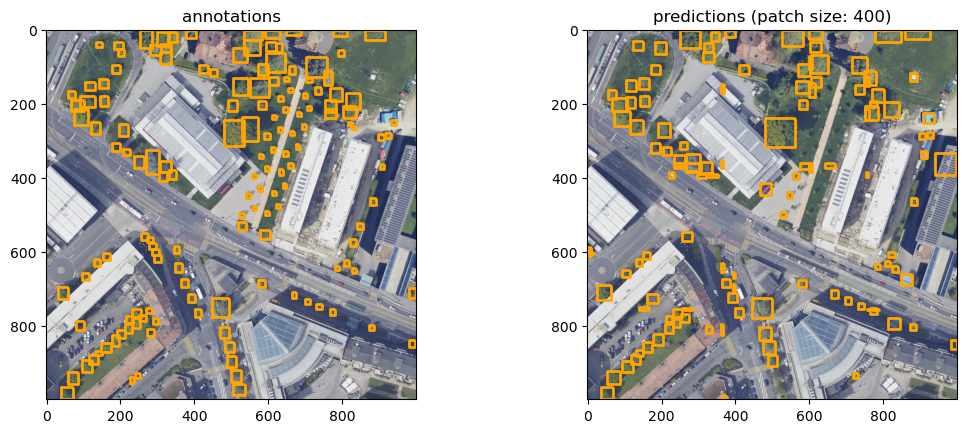

In [ ]:
fig = plot.plot_annot_vs_pred(
    annot_gdf,
    pred_gdf,
    tile_dir,
    legend=False,
    plot_annot_kwargs=plot_annot_kwargs,
    plot_pred_kwargs=plot_pred_kwargs,
)

At first glance, this seems a good zero-shot prediction and we can indeed see that the model performs better with a patch size somewhere in between 200 and 300 pixels. Let us now use proper metrics to confirm this.

### Evaluate predictions from the pre-trained model

We will now compute the following metrics:
- **intersection over union (IoU)**: the proportion of the area of overlap between the predicted and annotated bounding boxes to the area of their union
- **precision**: the proportion of predicted objects that have a ground truth positive match (for a given IoU threshold)
- **recall**: the proportion of ground truth objects that have a true positive match (for a given IoU threshold)
- **F1**: the harmonic mean of precision and recall, providing a measure of model performance that balances true positives and false negatives.

In [ ]:
metrics_df = deepforest_utils.compute_metrics_df(
    annot_gdf, pred_gdf, tile_dir, iou_threshold=iou_threshold
)
metrics_df

,IoU,recall,precision,f1
patch_size,,,,
200,0.557250,0.734694,0.262136,0.386404
300,0.570156,0.782313,0.547619,0.644258
400,0.467259,0.635593,0.635593,0.635593
500,0.428648,0.608696,0.608696,0.608696


The model shows the best IoU, recall and F1 with a patch size of 300 pixels. Only the precision is better with larger patch sizes, likely because there are fewer predictions with larger patch sizes. We can also show the metrics for each patch size as a bar plot:

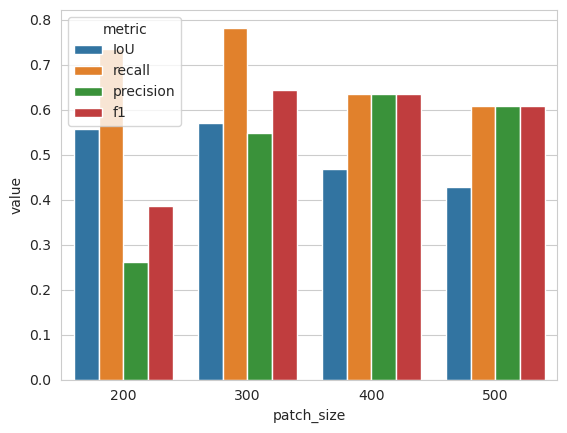

In [ ]:
with sns.axes_style("whitegrid"):
    plot.metrics_barplot(metrics_df)

## Train/fine-tune the pre-trained model

Let us now retrain the model using the annotations. Note that since we only have one annotated image, it most likely makes sense to use a small number of epohcs.

In [ ]:
# retrain model for tree crowns only
model = deepforest_utils.retrain_model(
    model, tile_dir, annot_gdf, epochs=epochs, gpus=gpus
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Reading config file: /home/martibosch/mambaforge/envs/swiss-urban-trees/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type                  | Params
-----------------------------------------------------
0 | model      | RetinaNet             | 32.1 M
1 | iou_metric | IntersectionOverUnion | 0     
2 | mAP_metric | MeanAveragePrecision  | 0     
-----------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)


Epoch 0:   0%|                                                  | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████| 1/1 [00:08<00:00,  0.12it/s, v_num=25]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|████████████████████████████████| 1/1 [00:08<00:00,  0.12it/s, v_num=25]
--- Model retrained in 16.27 seconds ---


In [ ]:
# pred_df[pred_df["image_path"] == img_filename]
# print(pred_df["image_path"].unique(), annot_df["image_path"].unique())
retrain_pred_df = pd.concat(
    [
        model.predict_tile(
            path.join(tile_dir, f"{path.splitext(img_filename)[0]}.tif"),
            patch_size=patch_size,
            patch_overlap=patch_overlap,
            iou_threshold=iou_threshold,
        ).assign(**{"patch_size": patch_size})
        for img_filename in img_filenames
        for patch_size in patch_sizes
    ]
)

Predicting DataLoader 0: 100%|████████████████████████| 36/36 [01:33<00:00,  0.38it/s]
757 predictions in overlapping windows, applying non-max supression
603 predictions kept after non-max suppression
Predicting DataLoader 0: 100%|████████████████████████| 16/16 [00:41<00:00,  0.39it/s]
365 predictions in overlapping windows, applying non-max supression
270 predictions kept after non-max suppression
Predicting DataLoader 0: 100%|██████████████████████████| 9/9 [00:23<00:00,  0.39it/s]
235 predictions in overlapping windows, applying non-max supression
178 predictions kept after non-max suppression
Predicting DataLoader 0: 100%|██████████████████████████| 9/9 [00:23<00:00,  0.39it/s]
221 predictions in overlapping windows, applying non-max supression
122 predictions kept after non-max suppression


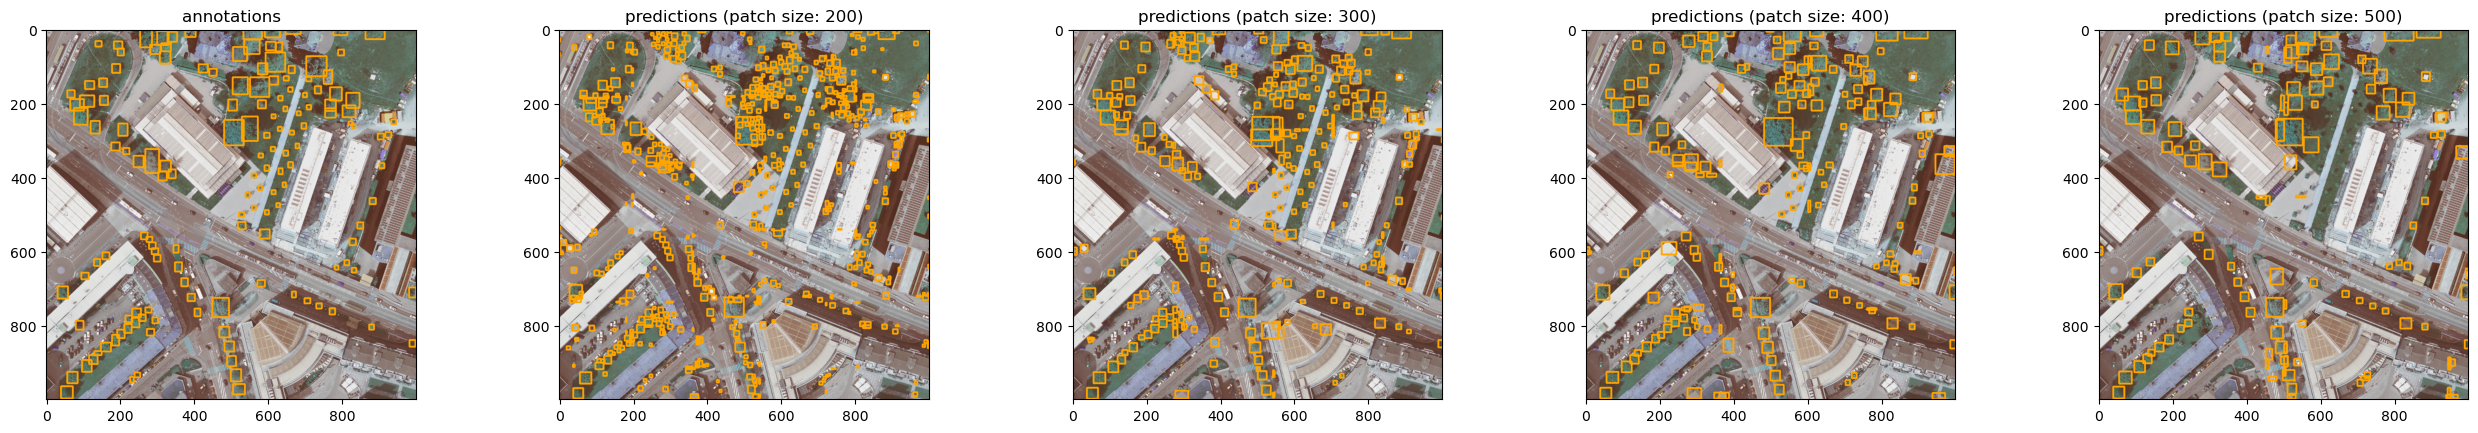

In [ ]:
# plot annotations and retrained model predictions with different patch sizes
fig = plot.plot_annot_vs_pred(
    annot_gdf,
    retrain_pred_df,
    tile_dir,
    plot_annot_kwargs=plot_annot_kwargs,
    plot_pred_kwargs=plot_pred_kwargs,
)

### Evaluate predictions from the fine-tuned model

**ACHTUNG**: note that we will be evaluating the predictions over the same tile used for training/fine-tuning, which should be avoided as it can result in issues such as *overfitting* and giving *highly misleading* impression of model performance. Ideally, we should *always* evaluate on test data that the model has not seen during training. However, providing high quality manual annotations is time consuming and at the current moment this notebook is mainly intended for illustrative purposes.

In [ ]:
retrain_metrics_df = deepforest_utils.compute_metrics_df(
    annot_gdf, retrain_pred_df, tile_dir, iou_threshold=iou_threshold
)
retrain_metrics_df

,IoU,recall,precision,f1
patch_size,,,,
200,0.526717,0.673469,0.164179,0.264000
300,0.598932,0.816327,0.444444,0.575540
400,0.496425,0.700680,0.578652,0.633846
500,0.432003,0.606557,0.606557,0.606557


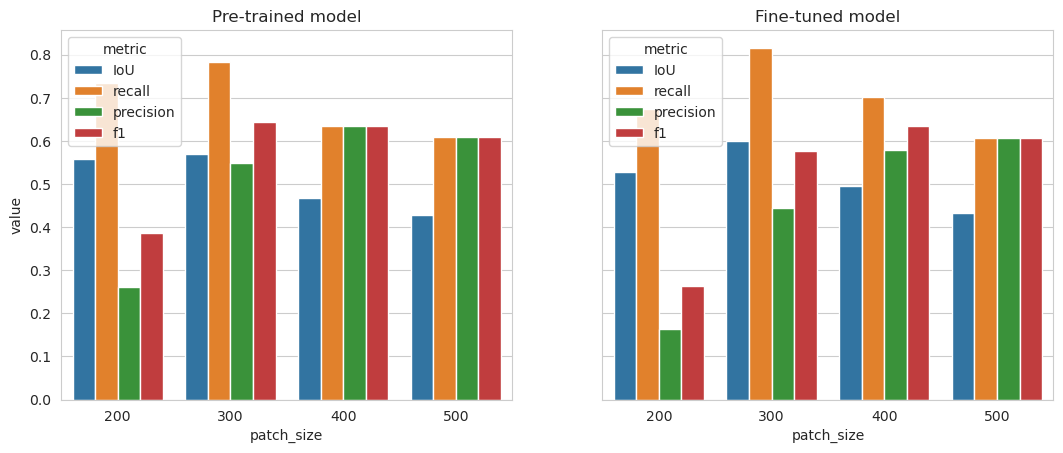

In [ ]:
# side-by-side comparison of metrics
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight), sharey=True)
    for df, title, ax in zip(
        [metrics_df, retrain_metrics_df],
        ["Pre-trained model", "Fine-tuned model"],
        axes,
    ):
        plot.metrics_barplot(df, ax=ax)
        ax.set_title(title)

As we can see, the fine-tuning improves the IoU and recall for the patch sizes of 300 and 400 pixels, but we can observe a downgrade in the precision, likely because more predictions occur with the fine-tuned model. The best F1 score is now with the patch size of 400 px, however it is lower than the F1 score of the pre-trained model with the 300 px patch size. Let us conclude by saving the fine-tuned model checkpoint:

In [ ]:
model.trainer.save_checkpoint(dst_model_filepath)

## References

1. Weinstein, B. G., Marconi, S., Aubry‐Kientz, M., Vincent, G., Senyondo, H., & White, E. P. (2020). DeepForest: A Python package for RGB deep learning tree crown delineation. Methods in Ecology and Evolution, 11(12), 1743-1751.